# Autoimmune GWAS genes vs perturb-seq clusters analysis

This notebook visualizes the results of the OpenTargets autoimmune disease enrichment analysis (output of opentargets_autoimmune_analysis.py).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata
from scipy.stats import fisher_exact
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

import sys
sys.path.append('../3_DE_analysis/')
from DE_analysis_utils import *

In [3]:
import yaml
with open('../../metadata/figure_palettes.yaml', 'r') as f:
    palettes = yaml.safe_load(f)

## Load Data

In [25]:
# Load disease-gene associations
disease_gene_df = pd.read_csv('disease_gene_associations_detailed.csv')

# Load disease-specific enrichment results
enrichment_df = pd.read_csv('cluster_disease_specific_enrichment_results.csv')

# Load clustering data to get cluster information
clustering_df = pd.read_csv('cluster_data_downloaded.csv')
clustering_df['cluster_member'] = [eval(x) for x in clustering_df['cluster_member']]
annot_columns = clustering_df.columns[clustering_df.columns.str.startswith('overlap_genes_')]

print(f"Disease-gene associations: {len(disease_gene_df)}")
print(f"Enrichment results: {len(enrichment_df)}")
print(f"Clustering data: {len(clustering_df)} clusters")

Disease-gene associations: 7527
Enrichment results: 648
Clustering data: 114 clusters


<Axes: >

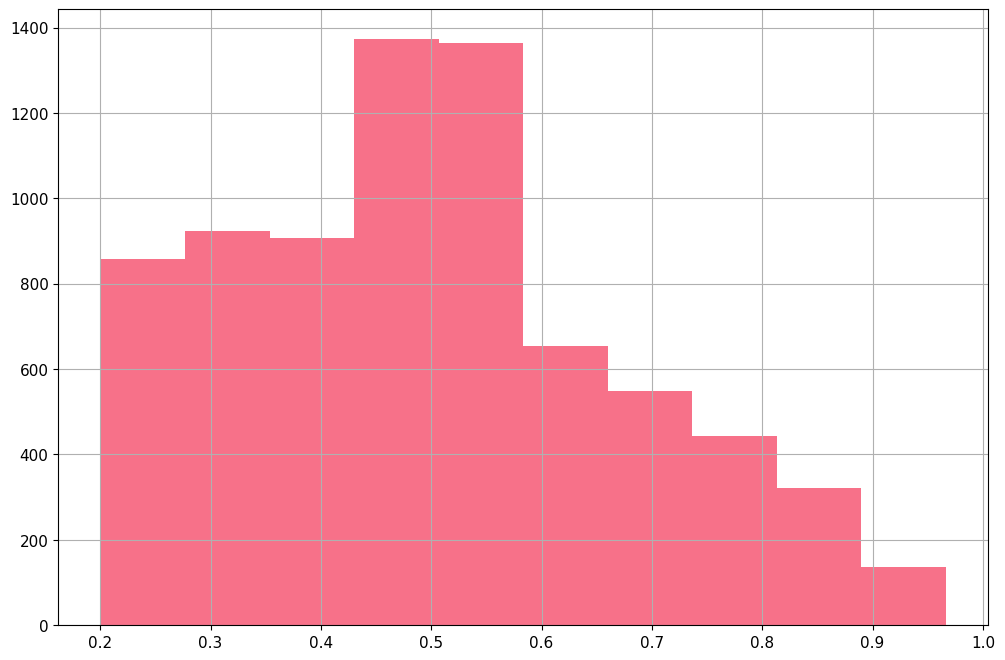

In [26]:
disease_gene_df.genetic_evidence_score.hist()

## Number of genes with genetic association for each disease

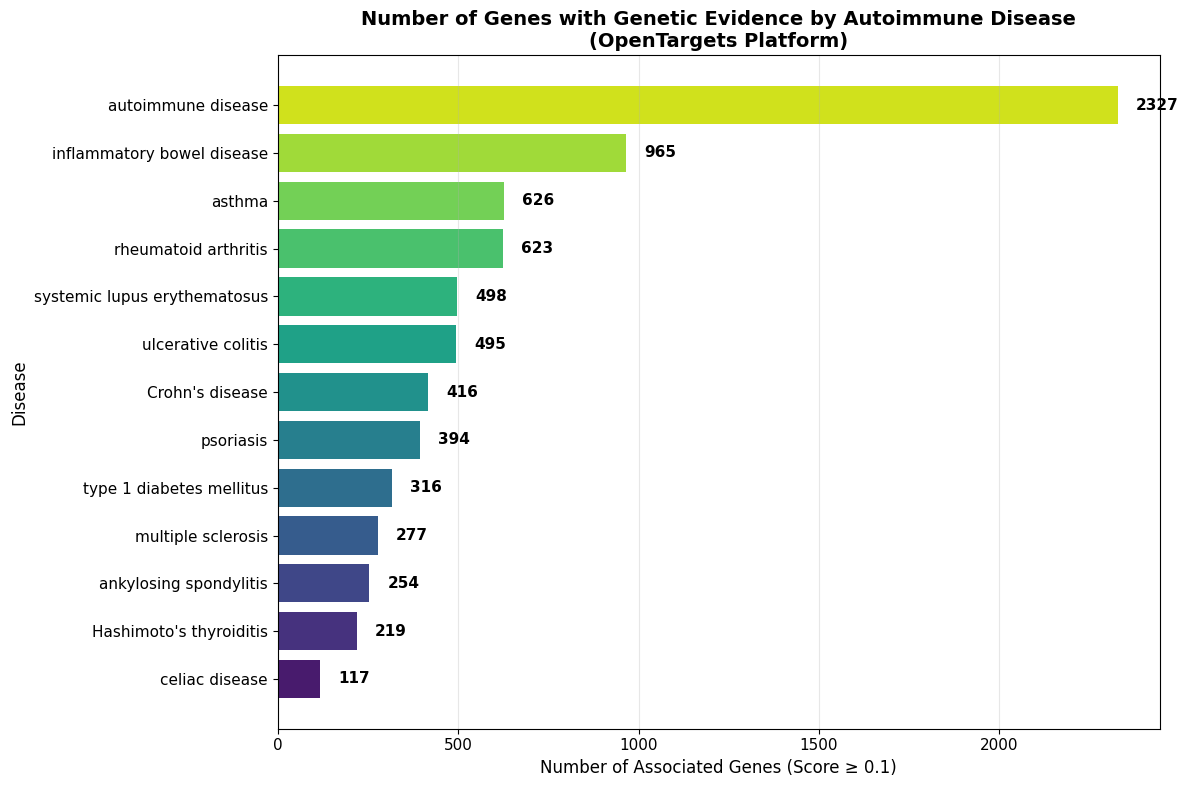


Genes per disease:
celiac disease: 117 genes
Hashimoto's thyroiditis: 219 genes
ankylosing spondylitis: 254 genes
multiple sclerosis: 277 genes
type 1 diabetes mellitus: 316 genes
psoriasis: 394 genes
Crohn's disease: 416 genes
ulcerative colitis: 495 genes
systemic lupus erythematosus: 498 genes
rheumatoid arthritis: 623 genes
asthma: 626 genes
inflammatory bowel disease: 965 genes
autoimmune disease: 2327 genes


In [27]:
# Count genes per disease (with score >= 0.1 threshold)
disease_gene_counts = disease_gene_df[disease_gene_df['association_score'] >= 0.1].groupby('disease_name')['gene_symbol'].nunique().reset_index()
disease_gene_counts.columns = ['Disease', 'Gene_Count']
disease_gene_counts = disease_gene_counts.sort_values('Gene_Count', ascending=True)

# Create barplot
plt.figure(figsize=(12, 8))
bars = plt.barh(disease_gene_counts['Disease'], disease_gene_counts['Gene_Count'], 
                color=sns.color_palette("viridis", len(disease_gene_counts)))

# Add value labels on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 50, bar.get_y() + bar.get_height()/2, 
             f'{int(width)}', ha='left', va='center', fontweight='bold')

plt.xlabel('Number of Associated Genes (Score ≥ 0.1)', fontsize=12)
plt.ylabel('Disease', fontsize=12)
plt.title('Number of Genes with Genetic Evidence by Autoimmune Disease\n(OpenTargets Platform)', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nGenes per disease:")
for _, row in disease_gene_counts.iterrows():
    print(f"{row['Disease']}: {row['Gene_Count']} genes")

## Odds ratios for each cluster and disease with significance indicators

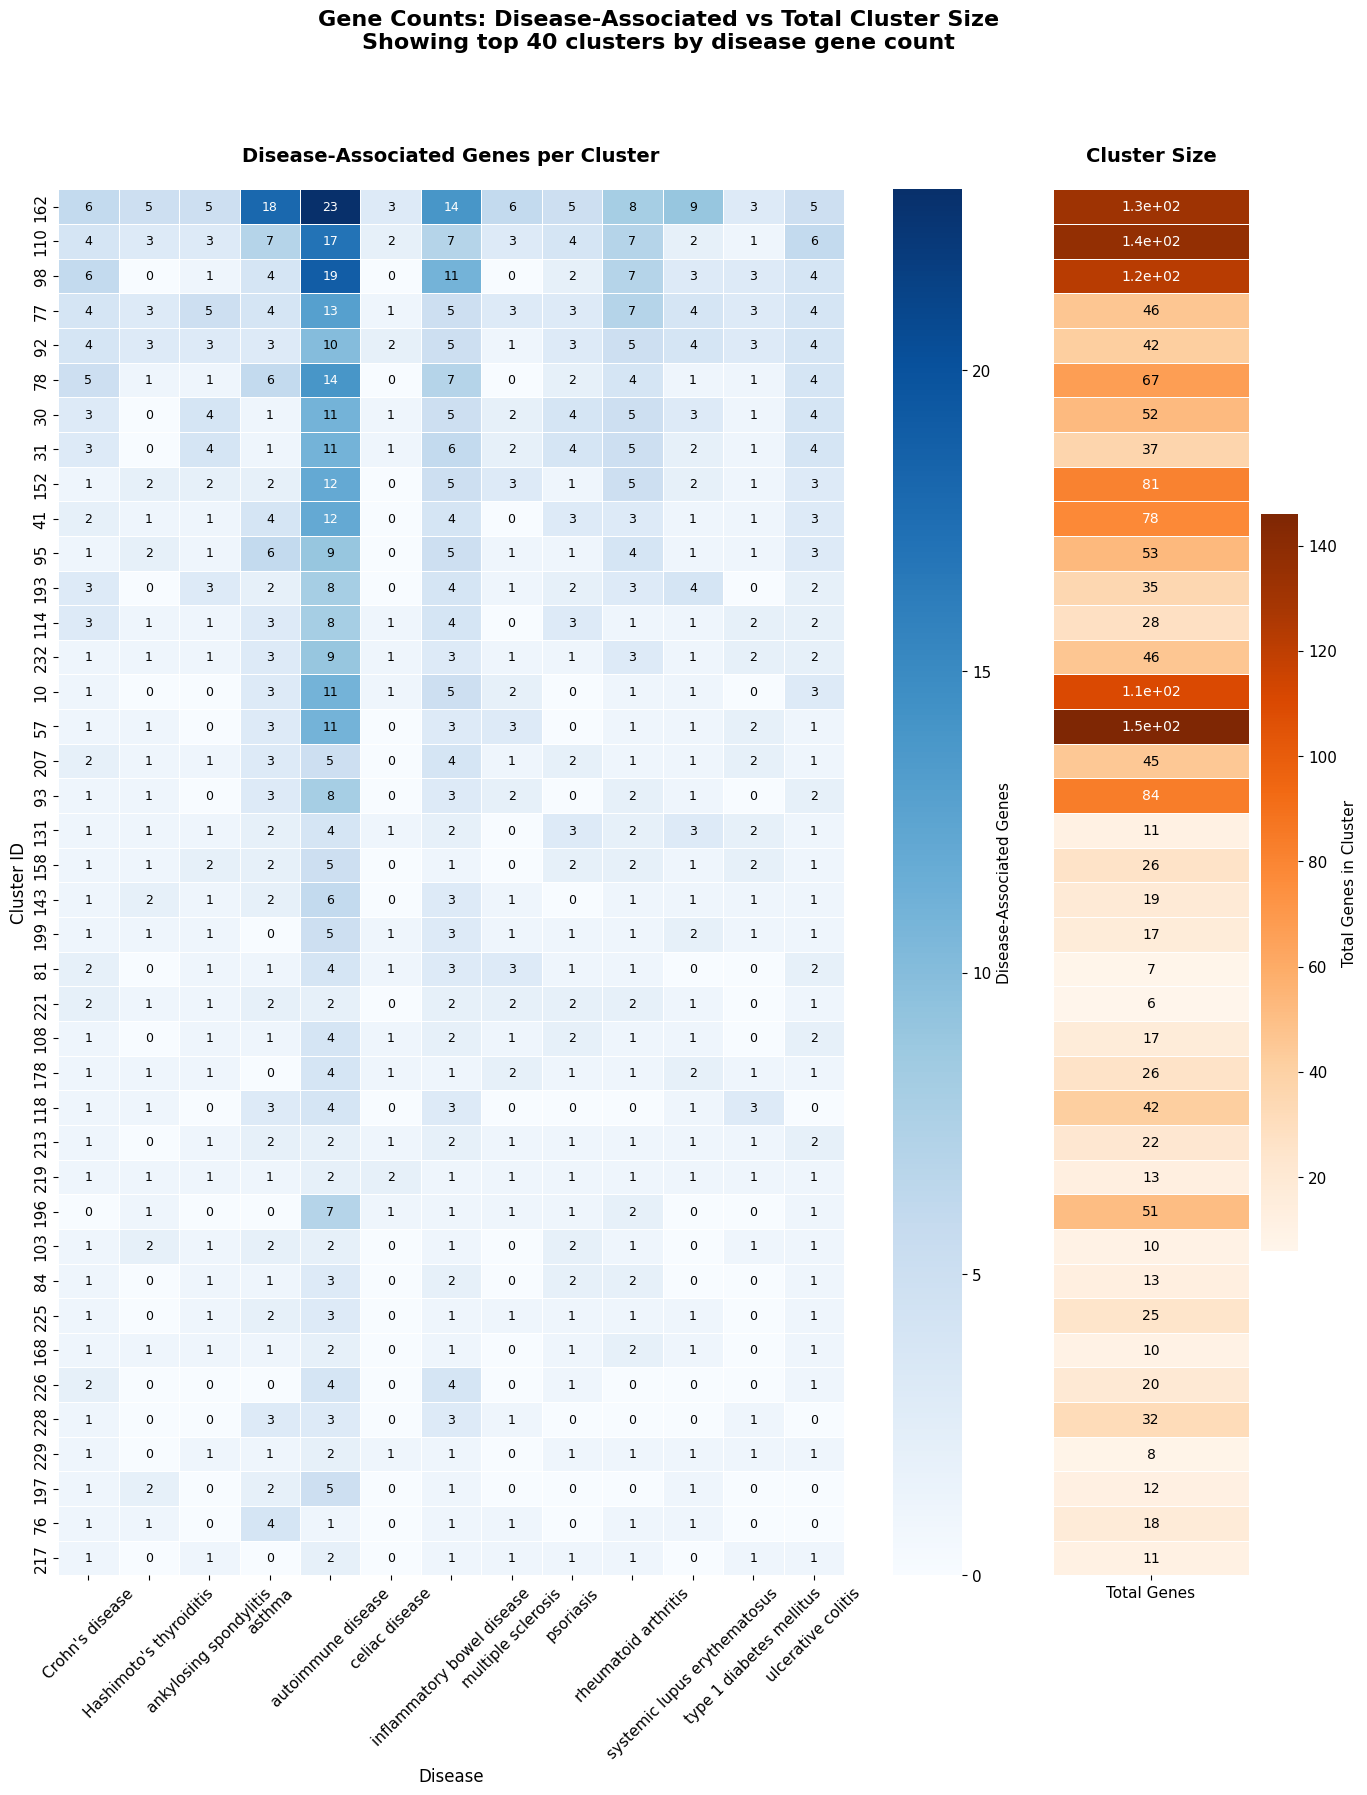


Showing top 40 clusters with most disease-associated genes
Total disease genes across all clusters: 1412.0

Top 10 clusters by disease gene count:
  Cluster 162: 110/132 genes (83.3% disease-associated)
  Cluster 110: 66/137 genes (48.2% disease-associated)
  Cluster 98: 60/122 genes (49.2% disease-associated)
  Cluster 77: 59/46 genes (128.3% disease-associated)
  Cluster 92: 50/42 genes (119.0% disease-associated)
  Cluster 78: 46/67 genes (68.7% disease-associated)
  Cluster 30: 44/52 genes (84.6% disease-associated)
  Cluster 31: 44/37 genes (118.9% disease-associated)
  Cluster 152: 39/81 genes (48.1% disease-associated)
  Cluster 41: 35/78 genes (44.9% disease-associated)


In [28]:
# Create heatmap showing count of disease-associated genes per cluster
gene_count_data = enrichment_df.pivot_table(
    index='cluster', 
    columns='disease', 
    values='disease_gene_count', 
    fill_value=0
)

# Get cluster sizes for the clusters we're showing
cluster_sizes = {}
for cluster in gene_count_data.index:
    cluster_info = clustering_df[clustering_df['cluster'] == cluster]
    if not cluster_info.empty:
        cluster_sizes[cluster] = len(cluster_info.iloc[0]['cluster_member'])
    else:
        cluster_sizes[cluster] = 0

# Sort clusters by total number of disease genes across all diseases
cluster_total_genes = gene_count_data.sum(axis=1).sort_values(ascending=False)
top_gene_clusters = cluster_total_genes.head(40).index  # Show top 40 clusters

# Filter data
gene_count_subset = gene_count_data.loc[top_gene_clusters]

# Create cluster size column for display
cluster_size_subset = pd.Series([cluster_sizes.get(cluster, 0) for cluster in top_gene_clusters], 
                               index=top_gene_clusters, name='Total Genes')

# Create the plot with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 18), 
                               gridspec_kw={'width_ratios': [4, 1], 'wspace': 0.02})

# Main heatmap
sns.heatmap(gene_count_subset, 
            cmap='Blues', 
            annot=True, 
            # fmt='d',  # Integer format
            cbar_kws={'label': 'Disease-Associated Genes'},
            xticklabels=True,
            yticklabels=True,
            linewidths=0.5,
            annot_kws={'size': 9},
            ax=ax1)

# Customize annotation colors (white text for dark cells, black for light)
for text in ax1.texts:
    try:
        text_val = float(text.get_text())
        text.set_color('white' if text_val > gene_count_subset.max().max() * 0.5 else 'black')
    except ValueError:
        pass

# Cluster size heatmap (single column)
cluster_size_2d = cluster_size_subset.values.reshape(-1, 1)
sns.heatmap(cluster_size_2d, 
            annot=True, 
            # fmt='d',
            cmap='Oranges',
            cbar_kws={'label': 'Total Genes in Cluster'},
            yticklabels=False,  # Don't repeat cluster labels
            xticklabels=['Total Genes'],
            linewidths=0.5,
            annot_kws={'size': 10},
            ax=ax2)

# Customize cluster size annotation colors
for text in ax2.texts:
    try:
        text_val = float(text.get_text())
        text.set_color('white' if text_val > cluster_size_subset.max() * 0.5 else 'black')
    except ValueError:
        pass

# Set titles and labels
ax1.set_title('Disease-Associated Genes per Cluster', fontsize=14, fontweight='bold', pad=20)
ax1.set_xlabel('Disease', fontsize=12)
ax1.set_ylabel('Cluster ID', fontsize=12)
ax1.tick_params(axis='x', rotation=45)

ax2.set_title('Cluster Size', fontsize=14, fontweight='bold', pad=20)
ax2.set_xlabel('', fontsize=12)
ax2.set_ylabel('', fontsize=12)

# Overall figure title
fig.suptitle('Gene Counts: Disease-Associated vs Total Cluster Size\nShowing top 40 clusters by disease gene count', 
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()
plt.show()

print(f"\nShowing top {len(top_gene_clusters)} clusters with most disease-associated genes")
print(f"Total disease genes across all clusters: {gene_count_data.sum().sum()}")

# Show top clusters by total disease gene count with percentages
print("\nTop 10 clusters by disease gene count:")
for cluster in top_gene_clusters[:10]:
    disease_count = int(cluster_total_genes[cluster])
    total_size = cluster_sizes.get(cluster, 0)
    percentage = (disease_count / total_size * 100) if total_size > 0 else 0
    print(f"  Cluster {cluster}: {disease_count}/{total_size} genes ({percentage:.1f}% disease-associated)")

Found 21 clusters with significant effects:
  FDR significant clusters: 4
  Nominally significant clusters: 21
  Unique clusters to show: 21


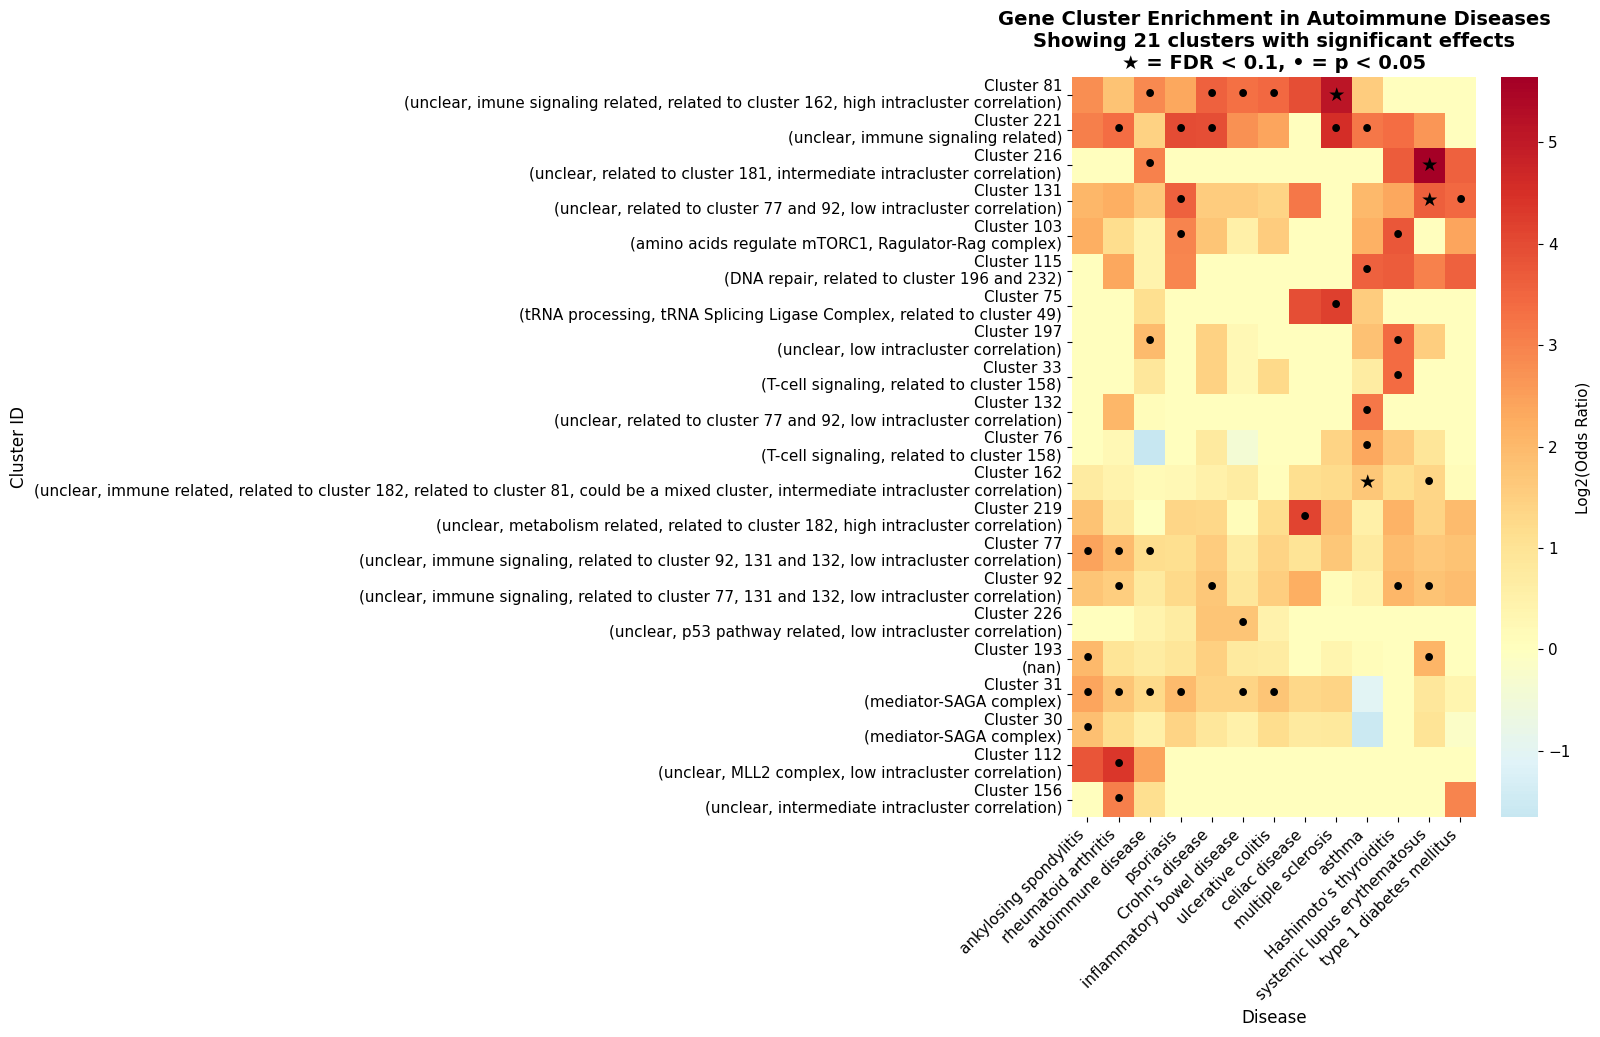


Showing all 21 clusters with significant effects
Clusters shown (sorted by max odds ratio):
  1. Cluster 216: Max OR = 49.85
     FDR significant: systemic lupus erythematosus
     Nominally significant: autoimmune disease
  2. Cluster 81: Max OR = 35.58
     FDR significant: multiple sclerosis
     Nominally significant: autoimmune disease, inflammatory bowel disease, Crohn's disease, ulcerative colitis
  3. Cluster 221: Max OR = 23.08
     Nominally significant: rheumatoid arthritis, multiple sclerosis, psoriasis, asthma, Crohn's disease
  4. Cluster 112: Max OR = 20.84
     Nominally significant: rheumatoid arthritis
  5. Cluster 75: Max OR = 18.45
     Nominally significant: multiple sclerosis
  6. Cluster 219: Max OR = 17.37
     Nominally significant: celiac disease
  7. Cluster 103: Max OR = 13.35
     Nominally significant: psoriasis, Hashimoto's thyroiditis
  8. Cluster 115: Max OR = 12.98
     Nominally significant: asthma
  9. Cluster 131: Max OR = 12.42
     FDR significan

In [29]:
from scipy.cluster import hierarchy

enrichment_df['cluster_annotation'] = [clustering_df[['cluster', 'manual_annotation']].drop_duplicates().set_index('cluster').loc[x].iloc[0] for x in enrichment_df.cluster]

# Prepare data for heatmap
heatmap_data = enrichment_df.pivot_table(
    index='cluster', 
    columns='disease', 
    values='odds_ratio', 
    fill_value=1.0
)

# Create significance indicators
sig_fdr = enrichment_df.pivot_table(
    index='cluster', 
    columns='disease', 
    values='p_adj_fdr', 
    fill_value=1.0
) < 0.1

sig_nominal = enrichment_df.pivot_table(
    index='cluster', 
    columns='disease', 
    values='p_value', 
    fill_value=1.0
) < 0.05

# Get clusters with ANY significant effect (FDR < 0.1 OR p < 0.05)
significant_clusters = set()

# Add FDR significant clusters
fdr_sig_clusters = enrichment_df[enrichment_df['p_adj_fdr'] < 0.1]['cluster'].unique()
significant_clusters.update(fdr_sig_clusters)

# Add nominally significant clusters  
nominal_sig_clusters = enrichment_df[enrichment_df['p_value'] < 0.05]['cluster'].unique()
significant_clusters.update(nominal_sig_clusters)

significant_clusters = list(significant_clusters)

print(f"Found {len(significant_clusters)} clusters with significant effects:")
print(f"  FDR significant clusters: {len(fdr_sig_clusters)}")
print(f"  Nominally significant clusters: {len(nominal_sig_clusters)}")
print(f"  Unique clusters to show: {len(significant_clusters)}")

# Sort significant clusters by maximum odds ratio for better visualization
cluster_max_or = heatmap_data.loc[significant_clusters].max(axis=1).sort_values(ascending=False)
significant_clusters_sorted = cluster_max_or.index.tolist()

# Filter data to show only significant clusters
heatmap_subset = heatmap_data.loc[significant_clusters_sorted]
sig_fdr_subset = sig_fdr.loc[significant_clusters_sorted] 
sig_nominal_subset = sig_nominal.loc[significant_clusters_sorted]

# Create the heatmap
plt.figure(figsize=(16, max(8, len(significant_clusters_sorted) * 0.5)))

# Use log scale for better visualization
log_odds = np.log2(heatmap_subset.clip(lower=0.1))  # Avoid log(0)
# Cluster rows and columns using hierarchical clustering
row_linkage = hierarchy.linkage(log_odds, method='average')
col_linkage = hierarchy.linkage(log_odds.T, method='average')

row_dendrogram = hierarchy.dendrogram(row_linkage, no_plot=True)
col_dendrogram = hierarchy.dendrogram(col_linkage, no_plot=True)

row_order = row_dendrogram['leaves']
col_order = col_dendrogram['leaves']

# Reorder rows and columns based on clustering
log_odds = log_odds.iloc[row_order].iloc[:, col_order]
sig_fdr_subset = sig_fdr_subset.iloc[row_order].iloc[:, col_order]
sig_nominal_subset = sig_nominal_subset.iloc[row_order].iloc[:, col_order]

# Create row labels with cluster ID and annotation
row_labels = [f"Cluster {cluster}\n({enrichment_df[enrichment_df['cluster']==cluster]['cluster_annotation'].iloc[0]})" 
              for cluster in log_odds.index]

# Create heatmap with clustered rows
ax = sns.heatmap(log_odds,
                 cmap='RdYlBu_r',
                 center=0,
                 annot=False, 
                 cbar_kws={'label': 'Log2(Odds Ratio)'},
                 xticklabels=True,
                 yticklabels=row_labels)

# Add significance indicators
for i in range(len(log_odds.index)):
    for j in range(len(log_odds.columns)):
        if sig_fdr_subset.iloc[i,j]:
            # FDR significant - star
            ax.text(j+0.5, i+0.5, '★', ha='center', va='center', 
                   color='black', fontsize=14, fontweight='bold')
        elif sig_nominal_subset.iloc[i,j]:
            # Nominally significant - dot
            ax.text(j+0.5, i+0.5, '•', ha='center', va='center', 
                   color='black', fontsize=16, fontweight='bold')

plt.title(f'Gene Cluster Enrichment in Autoimmune Diseases\nShowing {len(significant_clusters_sorted)} clusters with significant effects\n★ = FDR < 0.1, • = p < 0.05', 
          fontsize=14, fontweight='bold')
plt.xlabel('Disease', fontsize=12)
plt.ylabel('Cluster ID', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"\nShowing all {len(significant_clusters_sorted)} clusters with significant effects")
print("Clusters shown (sorted by max odds ratio):")
for i, cluster in enumerate(significant_clusters_sorted[:10], 1):
    max_or = cluster_max_or.loc[cluster]
    # Find which diseases are significant for this cluster
    cluster_results = enrichment_df[enrichment_df['cluster'] == cluster]
    fdr_diseases = cluster_results[cluster_results['p_adj_fdr'] < 0.1]['disease'].tolist()
    nominal_diseases = cluster_results[(cluster_results['p_value'] < 0.05) & (cluster_results['p_adj_fdr'] >= 0.1)]['disease'].tolist()
    
    print(f"  {i}. Cluster {cluster}: Max OR = {max_or:.2f}")
    if fdr_diseases:
        print(f"     FDR significant: {', '.join(fdr_diseases)}")
    if nominal_diseases:
        print(f"     Nominally significant: {', '.join(nominal_diseases)}")

print("Legend: ★ = FDR < 0.1, • = p < 0.05")

## Summaries for top enriched clusters

In [30]:
def print_enrichment_summary(row, clustering_df):
    """Print detailed enrichment summary for a single enrichment result.
    
    Args:
        row: A row from the enrichment_df DataFrame
        clustering_df: DataFrame containing cluster information
    """
    cluster_id = row['cluster']
    disease = row['disease']
    

    # Get cluster information
    cluster_info = clustering_df[clustering_df['cluster'] == cluster_id].iloc[0]
    
    # Parse genes from string representation
    import ast
    disease_genes = ast.literal_eval(row['disease_genes']) if isinstance(row['disease_genes'], str) else row['disease_genes']
    
    significance = "FDR < 0.05" if row['p_adj_fdr'] < 0.05 else "p < 0.05"
    
    print(f"\nCluster {cluster_id} - {disease}")
    print("-" * 50)
    print(f"Significance: {significance}")
    print(f"Enrichment: {row['disease_gene_count']}/{row['cluster_size']} genes ({row['disease_gene_count']/row['cluster_size']:.1%})")
    print(f"Odds Ratio: {row['odds_ratio']:.2f}")
    print(f"P-value: {row['p_value']:.2e}")
    if row['p_adj_fdr'] < 0.05:
        print(f"FDR: {row['p_adj_fdr']:.3f}")
    
    # Show pathway information from clustering data
    if pd.notna(cluster_info.get('complex_corum')):
        print(f"\nCORUM Complex: {cluster_info['complex_corum']}")
    if pd.notna(cluster_info.get('complex_reactome')):
        print(f"Reactome Pathway: {cluster_info['complex_reactome']}")
    if pd.notna(cluster_info.get('complex_kegg')):
        print(f"KEGG Pathway: {cluster_info['complex_kegg']}")
    
    print(f"\nDisease-associated genes ({len(disease_genes)}):")
    genes_per_line = 8
    for i in range(0, len(disease_genes), genes_per_line):
        gene_chunk = disease_genes[i:i+genes_per_line]
        print(f"  {', '.join(gene_chunk)}")
    
    

# Get top enriched results (FDR < 0.05 first, then top nominal)
fdr_significant = enrichment_df[enrichment_df['p_adj_fdr'] < 0.05].sort_values('p_adj_fdr')
nominal_significant = enrichment_df[(enrichment_df['p_value'] < 0.05) & (enrichment_df['p_adj_fdr'] >= 0.05)].sort_values('p_value').head(10)

top_results = pd.concat([fdr_significant, nominal_significant])

print("="*80)
print("TOP ENRICHED CLUSTERS: GENES AND PATHWAYS")
print("="*80)

for idx, (_, row) in enumerate(top_results.iterrows(), 1):
    print_enrichment_summary(row, clustering_df)
    if idx >= 10:  # Limit to top 10 for readability
        break

print(f"\n\nShowing top {min(10, len(top_results))} enriched clusters.")
print(f"Total FDR significant: {len(fdr_significant)}")
print(f"Total nominally significant: {len(enrichment_df[enrichment_df['p_value'] < 0.05])}")

TOP ENRICHED CLUSTERS: GENES AND PATHWAYS

Cluster 162 - asthma
--------------------------------------------------
Significance: FDR < 0.05
Enrichment: 18/132 genes (13.6%)
Odds Ratio: 3.21
P-value: 1.28e-04
FDR: 0.007

CORUM Complex: CASP8-CHUK-IKBKB-MALT1-BCL10 complex
Reactome Pathway: REACTOME_CREB_PHOSPHORYLATION
KEGG Pathway: KEGG_B_CELL_RECEPTOR_SIGNALING_PATHWAY

Disease-associated genes (18):
  CDK2, COG6, NUSAP1, MYO9A, PRKCQ, STAT5A, PDCD5, ICE2
  KAT2B, CD28, IKZF1, PTPRC, SIK3, FOXO1, PKN3, HTT
  TXNDC9, PIBF1

Cluster 81 - multiple sclerosis
--------------------------------------------------
Significance: FDR < 0.05
Enrichment: 3/7 genes (42.9%)
Odds Ratio: 35.58
P-value: 3.37e-04
FDR: 0.012

CORUM Complex: BCL10-MALT1 complex
Reactome Pathway: REACTOME_ACTIVATION_OF_NF_KAPPAB_IN_B_CELLS
KEGG Pathway: KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY

Disease-associated genes (3):
  MALT1, CD28, BCL10

Cluster 216 - systemic lupus erythematosus
--------------------------------------

## Novel Disease Gene Pairs Discovery

This section identifies pairs of disease-associated genes that cluster together but are not known to be part of the same pathway or complex, potentially revealing novel functional relationships.

In [31]:
def find_disease_gene_pairs_in_clusters(enrichment_df, disease_gene_df, clustering_df, known_relationships):
    """Find disease gene pairs within clusters, excluding known relationships"""
    
    novel_pairs = []
    
    print(f"Searching for novel pairs in all {len(clustering_df)} clusters...")
    
    # Get all unique diseases from our data
    all_diseases = disease_gene_df['disease_name'].unique()
    print(f"Diseases to check: {list(all_diseases)}")
    
    # Search in ALL clusters, not just enriched ones
    for _, cluster_row in clustering_df.iterrows():
        cluster_id = cluster_row['cluster']
        cluster_genes = set(cluster_row['cluster_member'])
        
        if len(cluster_genes) < 2:
            continue
            
        # For each disease, find which cluster genes are associated with it
        for disease in all_diseases:
            disease_genes_in_cluster = []
            
            # Find all genes in this cluster that are associated with this disease
            cluster_disease_genes = disease_gene_df[
                (disease_gene_df['disease_name'] == disease) & 
                (disease_gene_df['gene_symbol'].isin(cluster_genes)) &
                (disease_gene_df['association_score'] >= 0.1)  # Only include genes with decent evidence
            ]
            
            if len(cluster_disease_genes) >= 2:
                # We have multiple disease genes in this cluster
                disease_genes_in_cluster = cluster_disease_genes['gene_symbol'].unique().tolist()
                
                # Find all pairs of disease genes in this cluster
                for gene1, gene2 in combinations(disease_genes_in_cluster, 2):
                    if not gene1 or not gene2:  # Skip empty genes
                        continue
                        
                    gene_pair = tuple(sorted([gene1, gene2]))
                    
                    # Skip if this is a known relationship
                    if gene_pair in known_relationships:
                        continue
                    
                    # Get disease association scores for both genes
                    gene1_score = cluster_disease_genes[
                        cluster_disease_genes['gene_symbol'] == gene1
                    ]['association_score'].max()
                    
                    gene2_score = cluster_disease_genes[
                        cluster_disease_genes['gene_symbol'] == gene2
                    ]['association_score'].max()
                    
                    novel_pairs.append({
                        'cluster': cluster_id,
                        'disease': disease,
                        'gene1': gene1,
                        'gene2': gene2,
                        'gene1_score': gene1_score,
                        'gene2_score': gene2_score,
                        'pair_score_sum': gene1_score + gene2_score,
                        'pair_score_min': min(gene1_score, gene2_score),
                        'cluster_size': len(cluster_genes),
                        'disease_genes_in_cluster': len(disease_genes_in_cluster),
                        'cluster_enriched': cluster_id in enrichment_df['cluster'].values  # Track if cluster was significantly enriched
                    })
    
    print(f"Found {len(novel_pairs)} potential novel pairs across all clusters")
    return pd.DataFrame(novel_pairs)

In [32]:
def extract_known_relationships(clustering_df):
    """
    Generate a set of all pairs of genes that are in the same cluster 
    AND are also in the same complex/pathway according to annotation data.
    
    Parameters:
    -----------
    clustering_df : pandas.DataFrame
        DataFrame containing clustering results with pathway annotation columns
        
    Returns:
    --------
    set of tuples
        Set of gene pairs (gene1, gene2) where gene1 < gene2 alphabetically,
        representing known functional relationships from pathway annotations
    """
    
    print("Extracting known relationships from pathway annotations...")
    print(f"Clustering dataframe shape: {clustering_df.shape}")
    print(f"Available columns: {list(clustering_df.columns)}")
    
    # Find annotation columns that contain gene lists
    annotation_columns = [col for col in clustering_df.columns if col.startswith('overlap_genes_')]
    print(f"Using annotation columns: {annotation_columns}")
    
    known_pairs = set()
    
    for _, cluster_row in clustering_df.iterrows():
        cluster_id = cluster_row['cluster']
        cluster_genes = set(cluster_row['cluster_member'])
        
        # Check each annotation source
        for annot_col in annotation_columns:
            # Check if the column has valid data and contains genes
            if isinstance(cluster_row[annot_col], (list, set)) and len(cluster_row[annot_col]) > 1:
                # Get genes that overlap with this pathway/complex
                pathway_genes = set(cluster_row[annot_col])
                
                # Find genes that are both in the cluster AND in the same pathway
                shared_genes = cluster_genes.intersection(pathway_genes)
                
                # Add all pairs of shared genes as known relationships
                if len(shared_genes) >= 2:
                    for gene1, gene2 in combinations(shared_genes, 2):
                        if gene1 and gene2:  # Skip empty genes
                            # Store in sorted order to avoid duplicates
                            pair = tuple(sorted([gene1, gene2]))
                            known_pairs.add(pair)
    
    print(f"Found {len(known_pairs)} known gene relationships from pathway annotations")
    return known_pairs

In [33]:
from itertools import combinations

# Extract known relationships from pathway annotations
print("Step 1: Extracting known gene relationships...")
known_relationships = extract_known_relationships(clustering_df)
# Create long format dataframe of genes and their clusters
cl_df_long = pd.DataFrame([
    {'gene': gene, 'cluster': cluster} 
    for cluster, genes in zip(clustering_df['cluster'], clustering_df['cluster_member'])
    for gene in genes
])


# Process each disease
all_novel_pairs = {}

for disease_of_interest in disease_gene_df['disease_name'].unique():
    print(f"\nProcessing disease: {disease_of_interest}")
    
    # Filter and merge disease genes
    disease_cl_df = pd.merge(
        cl_df_long,
        disease_gene_df[disease_gene_df['disease_name'] == disease_of_interest].rename(columns={'gene_symbol':'gene'}),
        how='left'
    ).dropna()

    # Get all unique genes across clusters for this disease
    disease_genes = sorted(disease_cl_df['gene'].unique())
    print(f"Found {len(disease_genes)} genes associated with {disease_of_interest}")
    
    # Create list to store novel pairs
    novel_pairs_list = []

    # Find novel pairs within each cluster
    for cluster in disease_cl_df['cluster'].unique():
        cluster_genes = disease_cl_df[disease_cl_df['cluster'] == cluster]['gene'].unique().tolist()
        for gene1, gene2 in combinations(cluster_genes, 2):
            pair = tuple(sorted([gene1, gene2]))
            if pair not in known_relationships:
                novel_pairs_list.append({
                    'gene1': gene1,
                    'gene2': gene2,
                    'cluster': cluster,
                    'disease': disease_of_interest
                })

    # Convert to dataframe
    if novel_pairs_list:
        novel_cluster_pairs = pd.DataFrame(novel_pairs_list)
        novel_cluster_pairs = novel_cluster_pairs.drop_duplicates()
        novel_cluster_pairs = novel_cluster_pairs[novel_cluster_pairs['gene1'] != novel_cluster_pairs['gene2']]
        print(f"Found {len(novel_cluster_pairs)} novel gene pairs")
        all_novel_pairs[disease_of_interest] = novel_cluster_pairs
    else:
        print("No novel pairs found")

# Combine all results into one dataframe
final_novel_pairs = pd.concat(all_novel_pairs.values(), ignore_index=True)
print(f"\nTotal novel pairs across all diseases: {len(final_novel_pairs)}")
final_novel_pairs

Step 1: Extracting known gene relationships...
Extracting known relationships from pathway annotations...
Clustering dataframe shape: (114, 33)
Available columns: ['cluster', 'intracluster_corr', 'related_cluster', 'rest_count', 'stim8hr_count', 'stim48hr_count', 'signature_gene', 'cluster_member', 'manual_annotation', 'complex_corum', 'overlap_genes_corum', 'overlap_fraction_corum', 'raw_p_value_corum', 'complex_size_corum', 'complex_stringdb', 'overlap_genes_stringdb', 'overlap_fraction_stringdb', 'raw_p_value_stringdb', 'complex_size_stringdb', 'best_described_by', 'complex_kegg', 'overlap_genes_kegg', 'overlap_fraction_kegg', 'raw_p_value_kegg', 'complex_size_kegg', 'complex_reactome', 'overlap_genes_reactome', 'overlap_fraction_reactome', 'raw_p_value_reactome', 'complex_size_reactome', 'cluster_size', 'cluster_gene_size', 'cluster_member_with_condition']
Using annotation columns: ['overlap_genes_corum', 'overlap_genes_stringdb', 'overlap_genes_kegg', 'overlap_genes_reactome']
Fou

,gene1,gene2,cluster,disease
0,COG6,MMP9,78,Crohn's disease
1,COG6,ATP2A2,78,Crohn's disease
2,COG6,CISD1,78,Crohn's disease
3,MMP9,ATP2A2,78,Crohn's disease
4,MMP9,CISD1,78,Crohn's disease
...,...,...,...,...
2022,PRXL2B,MYRFL,95,ulcerative colitis
2023,CISD1,BRPF1,98,ulcerative colitis
2024,IRF8,FAM118A,193,ulcerative colitis
2025,CTNNB1,DOCK2,194,ulcerative colitis


## Odds Ratio Forest Plot

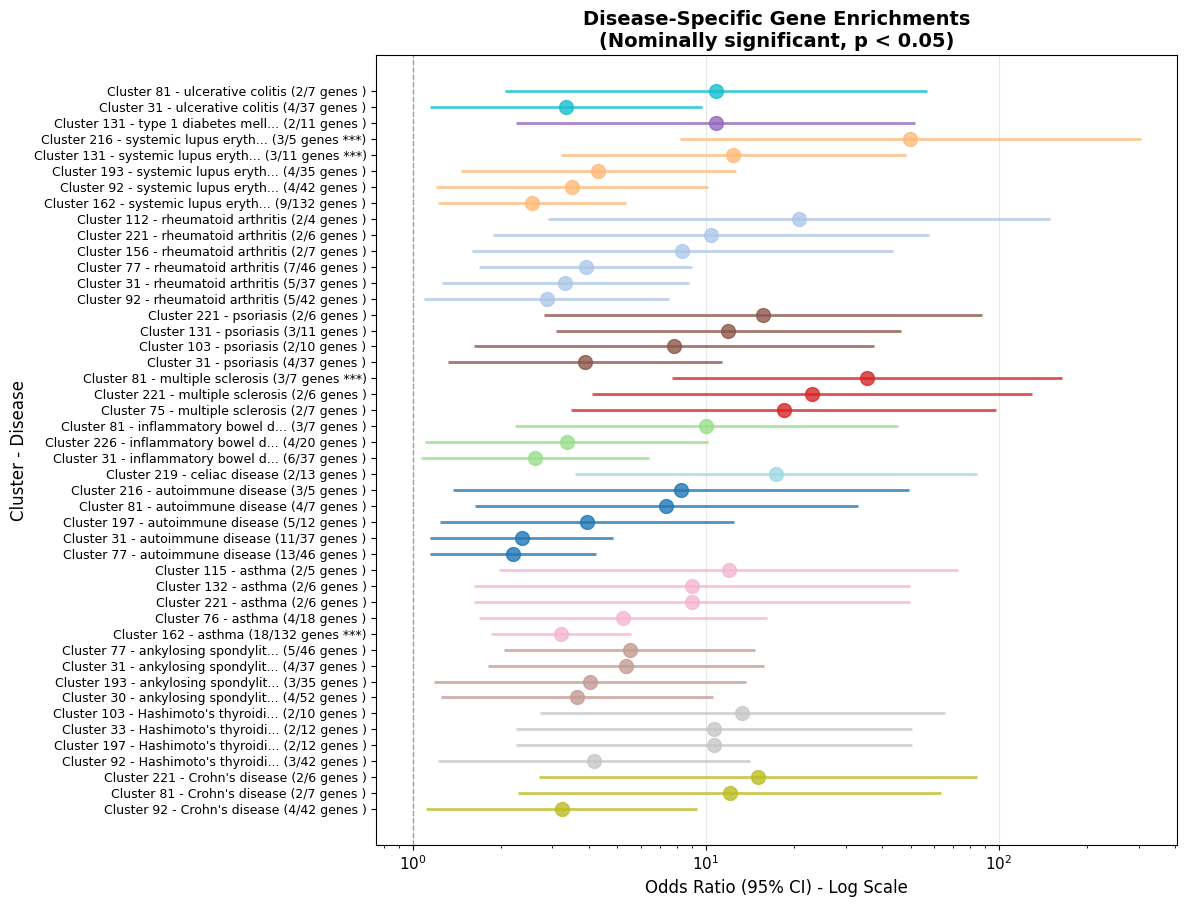

In [34]:
# Load disease-specific enrichment results  
disease_enrichment_df = pd.read_csv('cluster_disease_specific_enrichment_results.csv')

# Filter for nominally significant results (p < 0.05) and add confidence intervals if missing
disease_nominally_sig = disease_enrichment_df[disease_enrichment_df['p_value'] < 0.05].copy()

if len(disease_nominally_sig) > 0:
    # Create the forest plot
    fig, ax = plt.subplots(figsize=(12, max(8, len(disease_nominally_sig) * 0.2)))
    
    # Create color map for diseases
    unique_diseases = disease_nominally_sig['disease'].unique()
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_diseases)))
    disease_colors = dict(zip(unique_diseases, colors))
    
    # Sort within each disease by odds ratio
    disease_nominally_sig = disease_nominally_sig.sort_values(['disease', 'odds_ratio'], ascending=[True, True])
    
    # Plot odds ratios as points with confidence intervals
    y_positions = np.arange(len(disease_nominally_sig))
    
    for i, (_, row) in enumerate(disease_nominally_sig.iterrows()):
        color = disease_colors[row['disease']]
        ax.errorbar(row['odds_ratio'], i, 
                   xerr=[[row['odds_ratio'] - row['odds_ratio_ci_lower']], 
                         [row['odds_ratio_ci_upper'] - row['odds_ratio']]],
                   fmt='o', capsize=0, capthick=4, markersize=10,
                   color=color, ecolor=color, alpha=0.8, linewidth=2)
    
    # Add vertical line at OR = 1 (no effect)
    ax.axvline(x=1, color='gray', linestyle='--', alpha=0.7, linewidth=1)
    
    # Customize the plot
    cluster_labels = []
    for _, row in disease_nominally_sig.iterrows():
        fdr_status = "***" if row['p_adj_fdr'] < 0.1 else ""
        label = f"Cluster {row['cluster']} - {row['disease'][:20]}{'...' if len(row['disease']) > 20 else ''} ({row['disease_gene_count']}/{row['cluster_size']} genes {fdr_status})"
        cluster_labels.append(label)
    
    ax.set_yticks(y_positions)
    ax.set_yticklabels(cluster_labels, fontsize=9)
    ax.set_xlabel('Odds Ratio (95% CI)', fontsize=12)
    ax.set_ylabel('Cluster - Disease', fontsize=12)
    ax.set_title(f'Disease-Specific Gene Enrichments\n(Nominally significant, p < 0.05)', 
                 fontsize=14, fontweight='bold')
    
    # Use log scale for x-axis if there's a wide range
    max_or = disease_nominally_sig['odds_ratio_ci_upper'].max()
    if max_or > 10:
        ax.set_xscale('log')
        ax.set_xlabel('Odds Ratio (95% CI) - Log Scale', fontsize=12)
    
    # Add grid
    ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
    
    
else:
    print("No disease-specific nominally significant results to plot")

## Follow-up analysis on specific clusters

In [35]:
enrichment_df[(enrichment_df['disease'] == 'asthma')].sort_values('p_value')

,disease,cluster,cluster_size,disease_gene_count,disease_genes,odds_ratio,odds_ratio_ci_lower,odds_ratio_ci_upper,p_value,enrichment_fold,p_adj_fdr,cluster_annotation
438,asthma,162,132,18,"['CDK2', 'COG6', 'NUSAP1', 'MYO9A', 'PRKCQ', '...",3.205679,1.853466,5.544410,0.000128,2.540135,0.006765,"unclear, immune related, related to cluster 18..."
439,asthma,76,18,4,"['PTPRC', 'UBE2E2', 'ARHGAP27', 'ITK']",5.215873,1.682724,16.167433,0.013335,4.139480,0.353378,"T-cell signaling, related to cluster 158"
440,asthma,115,5,2,"['FIGNL1', 'RAD51B']",11.985507,1.978216,72.617143,0.025643,7.451064,0.393608,"DNA repair, related to cluster 196 and 232"
441,asthma,221,6,2,"['PTPRC', 'XPO6']",8.983696,1.624283,49.687654,0.037133,6.209220,0.393608,"unclear, immune signaling related"
442,asthma,132,6,2,"['ICOS', 'MFHAS1']",8.983696,1.624283,49.687654,0.037133,6.209220,0.393608,"unclear, related to cluster 77 and 92, low int..."
443,asthma,95,53,6,"['ICOS', 'FADS1', 'RAF1', 'ZBTB1', 'NPAS2', 'P...",2.335590,0.972275,5.610531,0.060810,2.108792,0.537158,"unclear, intermediate intracluster correlation"
444,asthma,211,20,3,"['TBX21', 'BCL3', 'SMAD4']",3.180349,0.915369,11.049770,0.088088,2.794149,0.641972,"unclear, immune signaling related, related to ..."
445,asthma,103,10,2,"['FOXO1', 'PTEN']",4.480978,0.938159,21.402731,0.096901,3.725532,0.641972,"amino acids regulate mTORC1, Ragulator-Rag com..."
446,asthma,131,11,2,"['ZNF76', 'ADAM19']",3.980676,0.847834,18.689732,0.114423,3.386847,0.673827,"unclear, related to cluster 77 and 92, low int..."
447,asthma,197,12,2,"['DMAC1', 'DTWD1']",3.580435,0.773232,16.579135,0.132678,3.104610,0.690469,"unclear, low intracluster correlation"


Load perturb-seq results

In [36]:
datadir = '/mnt/oak/users/emma/data/GWT/CD4i_final/'
adata_de = sc.read_h5ad(datadir + f'/DE_results_all_confounders/CD4i_final.merged_DE_results.h5ad')
adata_de.layers['zscore'] = adata_de.layers['log_fc'] / adata_de.layers['lfcSE']
adata_de.layers['zscore'][np.where(adata_de.layers['zscore'] > 50)] = 50

# Filter very lowly expressed genes
base_mean_df = sc.get.obs_df(adata_de, adata_de.var_names.tolist() + ['culture_condition', 'chunk'], layer='baseMean')
base_mean_df = base_mean_df.drop_duplicates().sort_values('culture_condition')

# Calculate for Rest condition
base_mean_rest = base_mean_df[base_mean_df['culture_condition'] == 'Rest'].set_index('chunk').drop('culture_condition', axis=1).T
adata_de.var['mean_baseMean_Rest'] = base_mean_rest.mean(1).fillna(0)
adata_de.var['std_baseMean_Rest'] = base_mean_rest.std(1).fillna(10000)

# Calculate for Stim8hr condition
base_mean_stim8 = base_mean_df[base_mean_df['culture_condition'] == 'Stim8hr'].set_index('chunk').drop('culture_condition', axis=1).T
adata_de.var['mean_baseMean_Stim8hr'] = base_mean_stim8.mean(1).fillna(0)
adata_de.var['std_baseMean_Stim8hr'] = base_mean_stim8.std(1).fillna(10000)

# Calculate for Stim48hr condition
base_mean_stim48 = base_mean_df[base_mean_df['culture_condition'] == 'Stim48hr'].set_index('chunk').drop('culture_condition', axis=1).T
adata_de.var['mean_baseMean_Stim48hr'] = base_mean_stim48.mean(1).fillna(0)
adata_de.var['std_baseMean_Stim48hr'] = base_mean_stim48.std(1).fillna(10000)

# Exclude from analysis genes with very low base mean (messing up reliability estimate)
gs_mask = (adata_de.var['mean_baseMean_Rest'] > 0.1) & (adata_de.var['mean_baseMean_Stim8hr'] > 0.1) & (adata_de.var['mean_baseMean_Stim48hr'] > 0.1)
adata_de = adata_de[:, gs_mask].copy()
sum(~gs_mask)

3677

In [37]:
adata_de.var_names = adata_de.var['gene_name'].values

In [38]:
de_stats = pd.read_csv(datadir + f'/DE_results_all_confounders/DE_summary_stats_per_target.csv', index_col=0)
de_stats.head()

,target_contrast,target_name,condition,n_cells_target,n_up_genes,n_down_genes,n_total_de_genes,ontarget_effect_size,ontarget_significant,baseMean,offtarget_flag,n_total_genes_category,ontarget_effect_category
0,ENSG00000012963,UBR7,Stim8hr,491.0,0,2,2,-12.952742,True,43.169196,True,2-10 DE genes,on-target KD
1,ENSG00000017260,ATP2C1,Stim8hr,469.0,0,1,1,-16.307246,True,102.399025,False,1 DE gene,on-target KD
2,ENSG00000067606,PRKCZ,Stim8hr,427.0,1,1,2,-1.658755,False,0.965897,False,2-10 DE genes,no on-target KD
3,ENSG00000092929,UNC13D,Stim8hr,830.0,0,2,2,-19.259466,True,60.904483,False,2-10 DE genes,on-target KD
4,ENSG00000100504,PYGL,Stim8hr,414.0,1,0,1,0.000000,False,NaN,False,1 DE gene,no on-target KD


In [39]:
disease_gs = disease_gene_df['gene_symbol'].unique()
disease_de_stats = de_stats[de_stats.target_name.isin(disease_gs)].copy()
# Count genes with on-target KD in at least one condition
genes_with_ontarget = disease_de_stats[disease_de_stats['ontarget_effect_category'] == 'on-target KD']['target_name'].unique()
print(f"Number of genes with on-target KD in at least one condition: {len(genes_with_ontarget)}/{len(disease_gs)}")

Number of genes with on-target KD in at least one condition: 1340/2989


In [41]:
disease_de_stats[disease_de_stats['ontarget_effect_category'] == 'on-target KD'].value_counts(['n_total_genes_category', 'condition'])

n_total_genes_category  condition
2-10 DE genes           Stim48hr     560
                        Stim8hr      543
                        Rest         539
>10 DE genes            Stim8hr      390
                        Rest         337
                        Stim48hr     333
1 DE gene               Stim48hr     297
                        Stim8hr      286
                        Rest         274
Name: count, dtype: int64

In [42]:
### PLOT THIS ON LESS GENES ###

# for d in  disease_gene_df.disease_name.unique():
#     if d != 'autoimmune disease':
#         disease_gs = disease_gene_df[disease_gene_df['disease_name'] == d]['gene_symbol'].unique()
#         disease_de_stats = de_stats[de_stats.target_name.isin(disease_gs)].copy()

#         # Sort targets by mean number of DE genes across conditions
#         target_order = disease_de_stats.groupby('target_name')['n_total_de_genes'].mean().sort_values().index

#         # Define condition order and colors
#         condition_order = ['Rest', 'Stim8hr', 'Stim48hr']

#         # Create figure with two subplots
#         fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(len(disease_de_stats.target_name.unique())*0.2, 9), height_ratios=[1, 2], sharex=True)

#         ## Top subplot: N cells barplot ##
#         sns.barplot(
#             data=disease_de_stats,
#             x='target_name', y='n_cells_target',
#             order=target_order,
#             color='lightgrey',
#             ax=ax1
#         )
#         ax1.set_yscale('log')
#         ax1.set_ylabel('# perturbed cells', fontsize=14)
#         ax1.tick_params(axis='y', labelsize=12)

#         ## Bottom subplot: N DE genes barplot ##
#         sns.barplot(
#             data=disease_de_stats,
#             x='target_name', 
#             y='n_total_de_genes',
#             hue='condition',
#             hue_order=condition_order,
#             order=target_order,
#             palette=palettes['culture_condition'],
#             ax=ax2
#         )

#         # Plot points for significant targets
#         points_data = disease_de_stats[disease_de_stats['ontarget_significant']].copy()
#         points_data['n_total_de_genes'] = points_data['n_total_de_genes'] * 1.1  # Offset by 10%

#         sns.stripplot(
#             data=points_data,
#             x='target_name', 
#             y='n_total_de_genes',
#             hue='condition',
#             dodge=True,
#             hue_order=condition_order,
#             order=target_order,
#             color='black',
#             size=3,
#             jitter=True,
#             zorder=10,
#             legend=False,
#             ax=ax2
#         )

#         ax2.set_yscale('log')
#         ax2.set_xlabel(f'{d} GWAS genes (Open Targets)', fontsize=14)
#         ax2.set_ylabel('# Significant DE genes (10% FDR)', fontsize=14)
#         ax2.tick_params(axis='x', rotation=90, labelsize=12)
#         ax2.tick_params(axis='y', labelsize=12)
#         ax2.legend(fontsize=12)
#         plt.tight_layout()


## Analysis of cluster 162

In [43]:
cl_id = 162
cl_members = clustering_df[clustering_df['cluster'] == cl_id]['cluster_member'].iloc[0]

# Get results for disease-associated genes
res_df = get_DE_results_long(
    adata_de, 
    targets=cl_members
    )
res_df = res_df[res_df['culture_condition'] == 'Stim48hr'].copy()

In [44]:
res_df['signif_up'] = np.where(res_df['significant'] & (res_df['zscore'] > 0), res_df['zscore'], 0)
res_df['signif_down'] = np.where(res_df['significant'] & (res_df['zscore'] < 0), res_df['zscore'], 0)

top_up_gs = res_df.pivot(index='gene', columns='target_contrast_gene_name', values='signif_up').mean(1).sort_values(ascending=False)[0:50].index.tolist()
top_down_gs = res_df.pivot(index='gene', columns='target_contrast_gene_name', values='signif_down').mean(1).sort_values(ascending=True)[0:50].index.tolist()
# [0:60].index.tolist()
# top_down_gs = res_df.pivot(index='gene', columns='target_contrast_gene_name', values='signif_down').sum(1).sort_values(ascending=False)[0:60].index.tolist()

print("Top upregulated genes:")
print(",\n".join([", ".join(top_up_gs[i:i+10]) for i in range(0, len(top_up_gs), 10)]))
print("\nTop downregulated genes:") 
print(",\n".join([", ".join(top_down_gs[i:i+10]) for i in range(0, len(top_up_gs), 10)]))

Top upregulated genes:
CD52, CD3D, ITGB2, EVL, FYB1, CD53, SUN2, MAL, ITM2A, SH3BGRL3,
TPP1, CTSB, PTPRC, IFI6, STK17B, AKNA, RNF19B, CD3E, CD96, HAVCR2,
PIK3CG, KMT2E, IL10RA, OAS3, C4orf3, LAPTM5, BAX, CLEC2D, YPEL3, FURIN,
GIMAP2, SH3BGRL, LY6E, GIMAP7, ABCD2, SAMD9L, DRAP1, SYTL2, NUCB1, CYTH4,
ATP2B4, WDTC1, RBL2, FMNL1, ICAM3, TP53INP1, ARL6IP5, ST3GAL1, EMB, DUSP5

Top downregulated genes:
HSPD1, HSP90AB1, PSAT1, TRAP1, SRM, NME2, BZW2, PSMG1, DCUN1D5, SLC1A5,
CYCS, EIF4A1, CCDC59, TUFM, CCT4, HSPE1, NME1, LYAR, CCT5, EIF4EBP1,
ODC1, SDHB, C1QBP, PFDN2, CCT6A, FABP5, ZC3H15, DESI1, BCCIP, CCT8,
TCP1, EXOSC8, YBX1, HSP90AA1, STOML2, SLC7A5, PYCR1, AHCY, VARS1, SSRP1,
HSPA9, MTHFD2, SNRPC, RUVBL1, DKC1, METTL5, LDHB, NARS1, STRAP, MLST8


In [45]:
enrichment_df[(enrichment_df['disease'] == 'asthma') & (enrichment_df.cluster==162)]

,disease,cluster,cluster_size,disease_gene_count,disease_genes,odds_ratio,odds_ratio_ci_lower,odds_ratio_ci_upper,p_value,enrichment_fold,p_adj_fdr,cluster_annotation
438,asthma,162,132,18,"['CDK2', 'COG6', 'NUSAP1', 'MYO9A', 'PRKCQ', '...",3.205679,1.853466,5.54441,0.000128,2.540135,0.006765,"unclear, immune related, related to cluster 18..."


In [46]:
from adjustText import adjust_text
cl_id = 162

# Read the CRISPRi screen phenotypes data
crispr_phenotypes = pd.read_csv('../../metadata/SchmidtSteinhart2022_CRISPRi_screen_gene_phenotypes.csv')
crispr_phenotypes = crispr_phenotypes[crispr_phenotypes.phenotype != 'Prim.CRi.CD4.IL2'].copy()
cl_members = eval(clustering_df[clustering_df['cluster'] == cl_id]['cluster_member'].iloc[0])

# Create volcano plot
plt.figure(figsize=(7, 5))
# Plot all points in grey
sns.scatterplot(x=crispr_phenotypes['effect_size'],
           y = -np.log10(crispr_phenotypes['pvalue']), s=5,
           alpha=0.5, color='grey', edgecolor=None)
# Highlight cluster members in red
sns.scatterplot(
    x=crispr_phenotypes[crispr_phenotypes.target.isin(cl_members)]['effect_size'],
    y= -np.log10(crispr_phenotypes[crispr_phenotypes.target.isin(cl_members)]['pvalue']), edgecolor=None,
           s=10, alpha=0.5, color='blue', label=f'cluster {cl_id} members')

# Add labels for significant cluster members
sig_members = crispr_phenotypes[
    ((crispr_phenotypes.target.isin(cl_members)) & 
    (crispr_phenotypes.pvalue < 0.001)) | (crispr_phenotypes.target == 'COG6')
]

texts = []
for _, row in sig_members.iterrows():
    texts.append(plt.text(
        row['effect_size'], 
        -np.log10(row['pvalue']), 
        row['target'],
        fontsize=12,
        color='blue'
    ))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', lw=0.5))

# Add labels
plt.xlabel('log2 Fold Change')
plt.ylabel('-log10(p-value)')
plt.title('IL2 CRISPRi screen (Schmidt 2022)')

# Add significance threshold line
plt.axhline(y=-np.log10(0.05), color='r', linestyle='--', alpha=0.3)

plt.show()

TypeError: eval() arg 1 must be a string, bytes or code object

In [ ]:
positive_tcr_regulators = [ # From Shifrut et al. 
   "CD3E",
   "CD3D", 
   "CD3G",
   "CD247",
   "CD28",
   "ZAP70",
   "LCK",
   "RHOH",
   'LCP2',
   "ITK",
   "VAV1",
   'PRKCQ',
   'CARD11', 
   'MALT1', 
   "BCL10",
   'TRAF6', 
   'LAT', 'IKBKB','IKBKG',
   "GRAP2",
   "PLCG1",
   "PDPK1",
   "NFKB1A",
   "REL", 'RELA'
]
np.intersect1d(cl_members, positive_tcr_regulators)

array(['BCL10', 'CD28', 'IKBKB', 'MALT1', 'PRKCQ'], dtype='<U8')

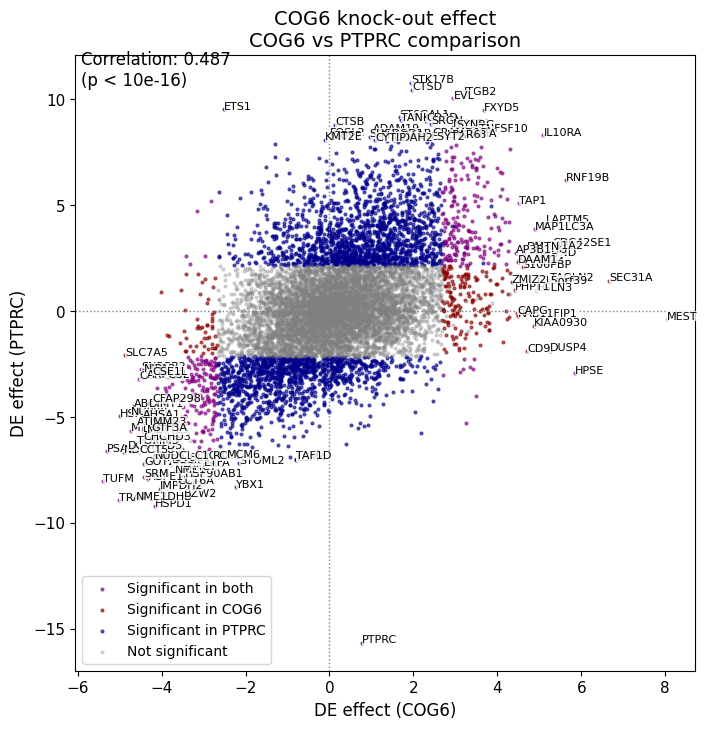

In [47]:
fig, ax = plt.subplots(figsize=(8, 8))
pl = plot_effect_comparison(
    adata_de, 
    {'target_contrast_gene_name':['COG6', 'PTPRC'], 'stat':['zscore'], 'culture_condition':['Stim48hr']},
    annotate_significant=True, n_top_genes=30, plot_correlation=True,
    ax=ax
    );

In [48]:
de_stats = pd.read_csv(datadir + f'/DE_results_all_confounders/DE_summary_stats_per_target.csv', index_col=0)
de_stats[de_stats['target_name'] == 'COG6']

,target_contrast,target_name,condition,n_cells_target,n_up_genes,n_down_genes,n_total_de_genes,ontarget_effect_size,ontarget_significant,baseMean,offtarget_flag,n_total_genes_category,ontarget_effect_category
11807,ENSG00000133103,COG6,Rest,161.0,639,188,827,-2.487363,False,4.423343,False,>10 DE genes,no on-target KD
32801,ENSG00000133103,COG6,Stim8hr,159.0,869,293,1162,-2.694524,True,5.708721,False,>10 DE genes,on-target KD
33102,ENSG00000133103,COG6,Stim48hr,110.0,388,284,672,-2.807496,True,9.071417,False,>10 DE genes,on-target KD


## Cluster 76

In [49]:
cl_id = 76
cl_members = clustering_df[clustering_df['cluster'] == cl_id]['cluster_member'].iloc[0]
print(cl_members)
# Get results for disease-associated genes
res_df = get_DE_results_long(
    adata_de, 
    targets=cl_members
    )
res_df = res_df[res_df['culture_condition'] == 'Rest'].copy()

['PLAT', 'LCK', 'PTPRC', 'SKIV2L', 'TMX1', 'SLC3A2', 'UBE2E2', 'LRBA', 'CALCOCO2', 'FITM2', 'PGGT1B', 'MTA3', 'ITK', 'APPL2', 'GPRASP1', 'PLEK2', 'ARHGAP27', 'MBD5']


In [50]:
print_enrichment_summary(enrichment_df[(enrichment_df['disease'] == 'asthma') & (enrichment_df['cluster'] == cl_id)].iloc[0], clustering_df)


Cluster 76 - asthma
--------------------------------------------------
Significance: p < 0.05
Enrichment: 4/18 genes (22.2%)
Odds Ratio: 5.22
P-value: 1.33e-02

CORUM Complex: CD4 receptor complex
Reactome Pathway: REACTOME_GENERATION_OF_SECOND_MESSENGER_MOLECULES
KEGG Pathway: KEGG_PRIMARY_IMMUNODEFICIENCY

Disease-associated genes (4):
  PTPRC, UBE2E2, ARHGAP27, ITK


In [51]:
clustering_df[clustering_df['cluster'] == cl_id].iloc[0]

cluster                                                                         76
intracluster_corr                                                         0.609284
related_cluster                                                              {158}
rest_count                                                                       0
stim8hr_count                                                                   18
stim48hr_count                                                                   0
signature_gene                                                                 NaN
cluster_member                   [PLAT, LCK, PTPRC, SKIV2L, TMX1, SLC3A2, UBE2E...
manual_annotation                         T-cell signaling, related to cluster 158
complex_corum                                                 CD4 receptor complex
overlap_genes_corum                                               ['PTPRC', 'LCK']
overlap_fraction_corum                                                    0.111111
raw_

In [52]:
enrichment_df[(enrichment_df['disease'] == 'asthma') & (enrichment_df['cluster'] == cl_id)].sort_values('p_value')

,disease,cluster,cluster_size,disease_gene_count,disease_genes,odds_ratio,odds_ratio_ci_lower,odds_ratio_ci_upper,p_value,enrichment_fold,p_adj_fdr,cluster_annotation
439,asthma,76,18,4,"['PTPRC', 'UBE2E2', 'ARHGAP27', 'ITK']",5.215873,1.682724,16.167433,0.013335,4.13948,0.353378,"T-cell signaling, related to cluster 158"


In [53]:
res_df['signif_up'] = np.where(res_df['significant'] & (res_df['zscore'] > 0), res_df['zscore'], 0)
res_df['signif_down'] = np.where(res_df['significant'] & (res_df['zscore'] < 0), res_df['zscore'], 0)

top_up_gs = res_df.pivot(index='gene', columns='target_contrast_gene_name', values='signif_up').mean(1).sort_values(ascending=False)[0:50].index.tolist()
top_down_gs = res_df.pivot(index='gene', columns='target_contrast_gene_name', values='signif_down').mean(1).sort_values(ascending=True)[0:50].index.tolist()
# [0:60].index.tolist()
# top_down_gs = res_df.pivot(index='gene', columns='target_contrast_gene_name', values='signif_down').sum(1).sort_values(ascending=False)[0:60].index.tolist()

print("Top upregulated genes:")
print(",\n".join([", ".join(top_up_gs[i:i+10]) for i in range(0, len(top_up_gs), 10)]))
print("\nTop downregulated genes:") 
print(",\n".join([", ".join(top_down_gs[i:i+10]) for i in range(0, len(top_up_gs), 10)]))

Top upregulated genes:
CYFIP2, RHOB, KLF6, EZR, IGSF9B, RHOA, KRAS, TSC22D3, ADGRE5, MAP3K4,
FOSL2, YWHAH, JAK2, IFITM2, SMAGP, CCSER2, CLDND1, NEK7, PATJ, TRAK2,
TMEM71, STAT6, CPNE1, GBP5, NFKBIZ, PCGF5, STK38L, CHCHD7, MARCHF8, KLRG1,
EMP3, MAP4, IFNG, CA6, S100A11, IL7R, PCM1, GLIPR2, RYBP, SELPLG,
SREBF1, JAZF1, TRIM22, JUN, FLNB, ILK, S100A10, GFUS, HBEGF, FTL

Top downregulated genes:
PTPRC, LAT, TMX1, ZAP70, CALCOCO2, CD3G, LRBA, CD3D, APPL2, LCK,
MTA3, CD3E, ARHGAP27, SLC3A2, EBP, ACTG1, BIN2, CXCR6, ELL2, GNLY,
PLCB2, GLIPR1, ITK, CD247, CDC37, PLCG1, MYDGF, OXCT1, C12orf75, CHMP4A,
CNN2, SEPTIN6, GATAD2B, PHF23, JAML, MKNK2, IRAK4, RNASET2, CBX5, CKAP2L,
BIRC5, TCF3, HNRNPA2B1, DENND2D, YBX3, TPX2, PKM, CORO1A, FUT8, MELK


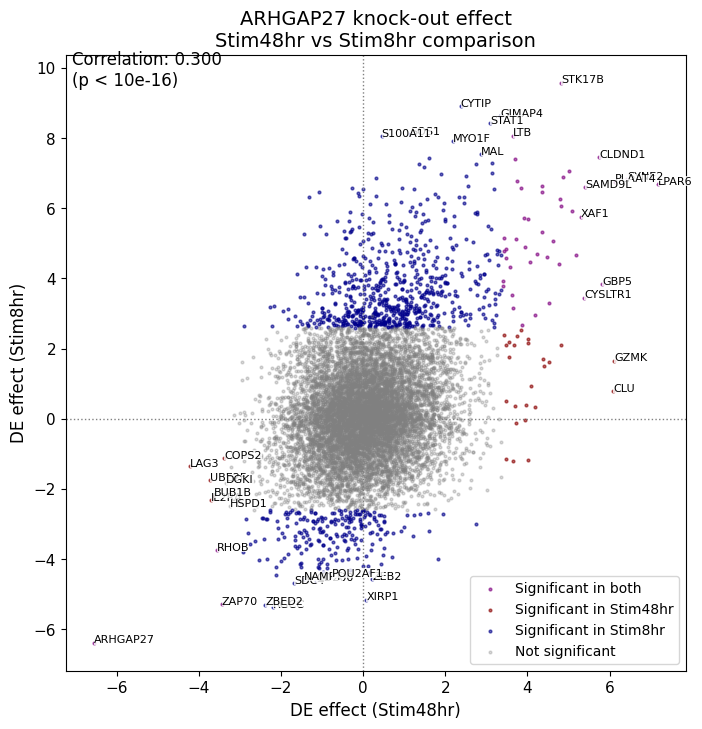

In [54]:
fig, ax = plt.subplots(figsize=(8, 8))
pl = plot_effect_comparison(
    adata_de, 
    {'target_contrast_gene_name':['ARHGAP27'], 'stat':['zscore'], 'culture_condition':['Stim8hr', "Stim48hr"]},
    annotate_significant=True, n_top_genes=10, plot_correlation=True,
    ax=ax
    );

In [55]:
de_stats = pd.read_csv(datadir + f'/DE_results_all_confounders/DE_summary_stats_per_target.csv', index_col=0)
de_stats[de_stats['target_name'] == 'ARHGAP27']

,target_contrast,target_name,condition,n_cells_target,n_up_genes,n_down_genes,n_total_de_genes,ontarget_effect_size,ontarget_significant,baseMean,offtarget_flag,n_total_genes_category,ontarget_effect_category
7267,ENSG00000159314,ARHGAP27,Stim48hr,201.0,68,8,76,-6.550189,True,29.924287,False,>10 DE genes,on-target KD
30197,ENSG00000159314,ARHGAP27,Stim8hr,234.0,709,225,934,-6.386096,True,23.812385,False,>10 DE genes,on-target KD
33364,ENSG00000159314,ARHGAP27,Rest,239.0,4,5,9,-8.555445,True,39.534745,False,2-10 DE genes,on-target KD


## Check genetic associations for follow-up hits in curation from Minikel et al. 

In [56]:
minikel_tab = pd.read_table('assoc.tsv.gz')

minikel_tab[
    (minikel_tab['gene'] == "ARHGAP27") & 
    (minikel_tab['original_trait'].str.contains('sthma', case=False))
].original_trait.unique()

array(['Asthma (childhood onset)', 'Age asthma diagnosed',
       'Allergic disease (asthma, hay fever or eczema)'], dtype=object)

In [57]:
minikel_tab[
    (minikel_tab['gene'] == "COG6") & 
    (minikel_tab['original_trait'].str.contains('sthma', case=False))
].original_trait.unique()

array(['Asthma (adult onset)', 'Asthma'], dtype=object)